In [1]:
!nvidia-smi

Sun Oct  1 12:34:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P4              13W / 140W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []

test_incorrect_pred={
    'images':[], 'ground_truths':[],'predicted_vals':[]
}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_curves():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")
  plt.show()

In [4]:
def get_misclassified_images(model,test_loader,device,n):
    if n%5!=0:
        return("give multiple of 5")
    model.eval()
    
    images               = []
    predictions          = []
    labels               = []
    with torch.no_grad():
        for inputs,targets in test_loader:
            inputs  = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _,pred = torch.max(outputs,1)

            for i in range(len(pred)):
                if pred[i]!=targets[i]:
                    images.append(inputs[i])
                    predictions.append(pred[i])
                    labels.append(targets[i])
    # return images,predictions,labels
    assert len(images) == len(predictions) == len(labels)

    images=images[:n]
    predictions=predictions[:n]
    labels=labels[:n]
    
    classes = test_loader.dataset.classes
    
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        sub = fig.add_subplot(len(images) // 5, 5, i + 1)
        image = images[i]
        image = image.T
        npimg = image.cpu().numpy().squeeze()
        plt.imshow(npimg, cmap="gray")
        predicted = classes[predictions[i]]
        correct = classes[labels[i]]
        sub.set_title(
            "Correct class: {}\nPredicted class: {}".format(correct, predicted)
        )
    plt.tight_layout()

In [5]:
def show_images(loader):
    inputs,classes = next(iter(loader))
    inputs=inputs[:10]
    classes=inputs[:10]
    out = torchvision.utils.make_grid(inputs)
    plt.imshow(out,title=[i for i in classes])

In [6]:
train_transforms =  transforms.Compose([
        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation((-10., 10.), fill=1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
        # transforms.autoaugment.AutoAugmentPolicy('cifar10')
    ])

test_transforms  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        )
    ])

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)


if device.type=='cuda':
    kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 4,'pin_memory':True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class ConvLayer(nn.Module):
    def __init__(self,inc:int,outc:int,k:int,p:int,norm:str,dp_rate:int,grp:int=0):
        super(ConvLayer,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=3,padding=p,bias=False),
            self.get_norm(norm=norm,grp=grp,num_f=outc),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dp_rate)
        )

    def get_norm(self,norm:str,num_f:int,grp:int=0):
        if norm=='bn':
            return nn.BatchNorm2d(num_features=num_f)
        elif norm=='ln':
            return nn.GroupNorm(num_groups=1,num_channels=num_f)
        elif norm=='gn':
            return nn.GroupNorm(num_groups=grp,num_channels=num_f)
        else:
            raise ValueError("choose bn/ln/gn")

    def forward(self,x):
        x = self.layer(x)
        return x


class TransBlock(nn.Module):
    def __init__(self,inc:int,outc:int):
        super(TransBlock,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=inc,out_channels=outc,kernel_size=1,bias=False),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
    def forward(self,x):
        x = self.layer(x)
        return x

# Normal Architecture

In [ ]:

class Model(nn.Module):
    def __init__(self,norm_method:str,grp:int):
        super(Model,self).__init__()
        self.dropout_rate = 0.2
        if not norm_method in('bn','ln','gn'):
            raise ValueError('choose bn/ln/gn')
        else:
            self.norm = norm_method
            if self.norm =='gn':
                self.grp=grp
            else:
                self.grp=0

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=16,k=3,p=1,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)
        )
        self.trans1 = TransBlock(inc=32,outc=16)
        
        self.conv2 = nn.Sequential(
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)
        )
        self.trans2 = TransBlock(inc=32,outc=16)
        
        self.conv3 = nn.Sequential(
            ConvLayer(inc=16,outc=16,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=16,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp),
            ConvLayer(inc=32,outc=64,p=1,k=3,norm=self.norm,dp_rate=self.dropout_rate,grp=self.grp)            
        )
        self.trans3 = TransBlock(inc=64,outc=16)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.out = nn.Conv2d(16,10,1,bias=False)
    
    def forward(self,x):
        x = self.trans1(self.conv1(x))
        x = self.trans2(self.conv2(x))
        x = self.trans3(self.conv3(x))
        x = self.gap(x)
        x = self.out(x)
        logit = F.log_softmax(x.view(-1,10), dim=1)
        return logit

In [ ]:
model = Model(norm_method='bn',grp=0,).to(device)
summary(model,(3,32,32))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  tl = test(model, device, test_loader)
  scheduler.step(tl)

fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

# With One Skip Architecture

In [ ]:
class NewModel1(nn.Module):
        def __init__(self,norm_method:str, grp:int=0,dp_rate=0.2):
            super(NewModel1,self).__init__()
            if not norm_method in('bn','ln','gn'):
                raise ValueError('choose bn/ln/gn')
            else:
                self.norm = norm_method
                if self.norm =='gn':
                    self.grp=grp
                else:
                    self.grp=0

            self.dp_rate=dp_rate

            self.C1 = ConvLayer(inc=3,outc=8,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=8,outc=8,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=8,outc=8)
            
            self.C4 = ConvLayer(inc=8,outc=12,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=12,outc=12,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=12,outc=20)

            self.C7 = ConvLayer(inc=20,outc=32,p=3,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=32,outc=32,p=3,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=32,outc=32,p=3,k=3,norm=self.norm,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = nn.Conv2d(in_channels=32,out_channels=10,kernel_size=1,stride=1,bias=False)
    
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = self.t1(x)
            x = self.t2( self.C5(  self.C4(x) ) )
            x = self.C9( self.C8(  self.C7(x) ) )
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [ ]:
rmodel = NewModel1(norm_method='bn',grp=0).to(device)
summary(rmodel,(3,32,32))

In [ ]:
train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []

test_incorrect_pred={
    'images':[], 'ground_truths':[],'predicted_vals':[]
}

optimizer = optim.SGD(rmodel.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(rmodel, device, train_loader, optimizer)
  tl = test(rmodel, device, test_loader)
  scheduler.step(tl)


fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

## Ablation result:
- reduced model size by half still delivers 82% accuracy
- skip connection works!!

# More Skip Architecture

In [ ]:
class NewModel3(nn.Module):
        def __init__(self,norm_method:str, grp:int=0,dp_rate=0.2):
            super(NewModel3,self).__init__()
            if not norm_method in('bn','ln','gn'):
                raise ValueError('choose bn/ln/gn')
            else:
                self.norm = norm_method
                if self.norm =='gn':
                    self.grp=grp
                else:
                    self.grp=0

            self.dp_rate=dp_rate

            self.C1 = ConvLayer(inc=3,outc=8,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=8,outc=8,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=8,outc=8)
            
            self.C4 = ConvLayer(inc=8,outc=12,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=12,outc=12,k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=12,outc=20)

            self.C7 = ConvLayer(inc=20,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=32,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=32,outc=32,p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = nn.Conv2d(in_channels=32,out_channels=10,kernel_size=1,stride=1,bias=False)
    
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = self.t1(x)

            x = self.C4(x)
            x = x + self.C5(x)
            x = self.t2(x)

            x = self.C7(x)
            x = x + self.C8(x)
            x = x + self.C9(x)
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [ ]:
res_model = NewModel3(norm_method='bn',grp=0,dp_rate=0.1).cuda()
summary(res_model,(3,32,32))

In [ ]:
train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []

test_incorrect_pred={
    'images':[], 'ground_truths':[],'predicted_vals':[]
}

optimizer = optim.SGD(res_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(res_model, device, train_loader, optimizer)
  tl = test(res_model, device, test_loader)
  scheduler.step(tl)



fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [8]:
class Net(nn.Module):
        def __init__(self,norm_method:str,channels:list=[3,8,12,20,32,10],grp:int=0,dp_rate=0.1):
            super(Net,self).__init__()
            if not norm_method in('bn','ln','gn'):
                raise ValueError('choose bn/ln/gn')
            else:
                self.norm = norm_method
                if self.norm =='gn':
                    self.grp=grp
                else:
                    self.grp=0

            self.dp_rate=dp_rate
            
            self.C1 = ConvLayer(inc=3,outc=channels[1],k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1],outc=channels[1],k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=channels[1],outc=channels[1])
            
            self.C4 = ConvLayer(inc=channels[1],outc=channels[2],k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2],outc=channels[2],k=3,p=1,norm=self.norm,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=channels[2],outc=channels[3])

            self.C7 = ConvLayer(inc=channels[3],outc=channels[4],p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[4],outc=channels[4],p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[4],outc=channels[4],p=1,k=3,norm=self.norm,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = nn.Conv2d(in_channels=channels[4],out_channels=channels[-1],kernel_size=1,stride=1,bias=False)
    
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = self.t1(x)

            x = self.C4(x)
            x = x + self.C5(x)
            x = self.t2(x)

            x = self.C7(x)
            x = x + self.C8(x)
            x = x + self.C9(x)
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [9]:
r_model = Net(norm_method='bn',channels=[3,16,20,28,40,10],grp=0,dp_rate=0.1).cuda()
summary(r_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvLayer-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
         Dropout2d-9           [-1, 16, 32, 32]               0
        ConvLayer-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             256
        MaxPool2d-12           [-1, 16, 16, 16]               0
       TransBlock-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 20,

Epoch 1


Train: Loss=1.4327 Batch_id=390 Accuracy=30.92: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.42it/s]


Test set: Average loss: 1.4782, Accuracy: 4420/10000 (44.20%)

Epoch 2


Train: Loss=1.2930 Batch_id=390 Accuracy=44.70: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.99it/s]


Test set: Average loss: 1.3648, Accuracy: 4855/10000 (48.55%)

Epoch 3


Train: Loss=1.3327 Batch_id=390 Accuracy=50.59: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.90it/s]


Test set: Average loss: 1.2267, Accuracy: 5526/10000 (55.26%)

Epoch 4


Train: Loss=1.4358 Batch_id=390 Accuracy=54.43: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 1.1464, Accuracy: 5929/10000 (59.29%)

Epoch 5


Train: Loss=1.0343 Batch_id=390 Accuracy=56.48: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.54it/s]


Test set: Average loss: 1.0173, Accuracy: 6407/10000 (64.07%)

Epoch 6


Train: Loss=1.1761 Batch_id=390 Accuracy=58.88: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.32it/s]


Test set: Average loss: 1.0019, Accuracy: 6374/10000 (63.74%)

Epoch 7


Train: Loss=1.1054 Batch_id=390 Accuracy=60.04: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.9782, Accuracy: 6550/10000 (65.50%)

Epoch 8


Train: Loss=1.0914 Batch_id=390 Accuracy=61.52: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.70it/s]


Test set: Average loss: 0.9773, Accuracy: 6408/10000 (64.08%)

Epoch 9


Train: Loss=0.9793 Batch_id=390 Accuracy=62.09: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.43it/s]


Test set: Average loss: 0.8660, Accuracy: 6857/10000 (68.57%)

Epoch 10


Train: Loss=1.0395 Batch_id=390 Accuracy=63.20: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.68it/s]


Test set: Average loss: 0.8994, Accuracy: 6831/10000 (68.31%)

Epoch 11


Train: Loss=0.9439 Batch_id=390 Accuracy=64.21: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.69it/s]


Test set: Average loss: 0.8608, Accuracy: 6876/10000 (68.76%)

Epoch 12


Train: Loss=0.9224 Batch_id=390 Accuracy=64.56: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.87it/s]


Test set: Average loss: 0.8415, Accuracy: 7000/10000 (70.00%)

Epoch 13


Train: Loss=0.8492 Batch_id=390 Accuracy=65.54: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.58it/s]


Test set: Average loss: 0.8514, Accuracy: 7048/10000 (70.48%)

Epoch 14


Train: Loss=1.0125 Batch_id=390 Accuracy=65.74: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.57it/s]


Test set: Average loss: 0.8139, Accuracy: 7162/10000 (71.62%)

Epoch 15


Train: Loss=0.9003 Batch_id=390 Accuracy=66.71: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.66it/s]


Test set: Average loss: 0.7617, Accuracy: 7325/10000 (73.25%)

Epoch 16


Train: Loss=0.8495 Batch_id=390 Accuracy=66.88: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.63it/s]


Test set: Average loss: 0.7762, Accuracy: 7298/10000 (72.98%)

Epoch 17


Train: Loss=0.8305 Batch_id=390 Accuracy=67.58: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.42it/s]


Test set: Average loss: 0.7373, Accuracy: 7397/10000 (73.97%)

Epoch 18


Train: Loss=0.9531 Batch_id=390 Accuracy=67.94: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.73it/s]


Test set: Average loss: 0.7670, Accuracy: 7253/10000 (72.53%)

Epoch 19


Train: Loss=0.8986 Batch_id=390 Accuracy=68.39: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.95it/s]


Test set: Average loss: 0.7344, Accuracy: 7386/10000 (73.86%)

Epoch 20


Train: Loss=0.9974 Batch_id=390 Accuracy=68.68: 100%|██████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.80it/s]


Test set: Average loss: 0.7452, Accuracy: 7425/10000 (74.25%)



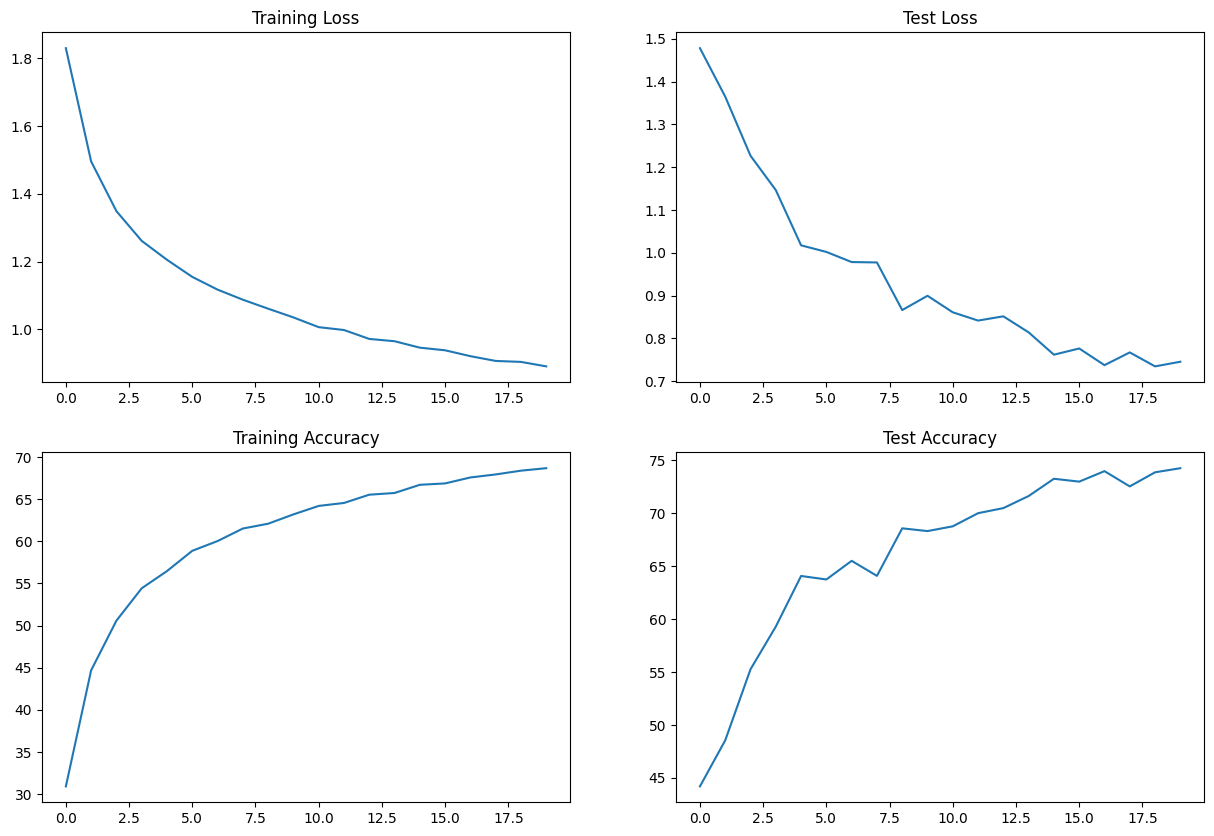

In [10]:
train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []

test_incorrect_pred={
    'images':[], 'ground_truths':[],'predicted_vals':[]
}

optimizer = optim.SGD(r_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(r_model, device, train_loader, optimizer)
  tl = test(r_model, device, test_loader)
  scheduler.step(tl)



fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()